# Compare reads classification from Kraken2
Aims to extract results from kraken2 reports, to present and compare results between batches
Sylvain @ GIS / Biopolis / Singapore
<Riondet_Sylvain_from.tp@gis.a-star.edu.sg>

Started on 2019-11-28

todo: bars in pandas tables <br>
http://pandas.pydata.org/pandas-docs/stable/user_guide/style.html

In [1]:
import ete3.ncbi_taxonomy
import imgkit
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as osp
import pandas as pd
from pathlib import Path
from sklearn.metrics import auc, average_precision_score, roc_auc_score

In [2]:
ncbi = ete3.ncbi_taxonomy.NCBITaxa()

In [3]:
pd.options.display.float_format = '{:.2f}'.format
# pd.set_option('precision', 5)

In [4]:
def get_desired_ranks(taxid, desired_ranks, tolist=False):
    """ From stackoverflow
        https://stackoverflow.com/questions/36503042/how-to-get-taxonomic-specific-ids-for-kingdom-phylum-class-order-family-gen
    """
    try:
        lineage = ncbi.get_lineage(taxid)
        lineage2ranks = ncbi.get_rank(lineage)
        ranks2lineage = dict((rank, taxid) for (taxid, rank) in lineage2ranks.items())
        if tolist: return [ranks2lineage.get(rank, 0) for rank in desired_ranks]
        else:      return {f'{rank}_id': ranks2lineage.get(rank, 0) for rank in desired_ranks}
    except:
        print(f"retrieval of the lineage of {taxid} failed")
        if tolist: return [0 for rank in desired_ranks]
        else:      return {f'{rank}_id': 0 for rank in desired_ranks}

In [5]:
def get_list_rank(taxids, desired_rank="species"):
    res = []
    for taxid in taxids:
        name = get_desired_ranks(taxid, [desired_rank], tolist=True)[0]
        res.append(name)
    return res

In [30]:
def div_z(n, d):
    return n / d if d else 0

In [45]:
class Report:
    kraken_cols = ["per_clade_covered", "reads_clade_covered", "reads_direct_taxo", "rank", "taxon", "scientific_name"]
    stats_col = {"taxon": int, "percentage": float}
    line_style = ['-.', '--', ':']
    obj_counter = 0
    benchmark = False
    
    def __init__(self, title, path=None):
        self.obj_id      = Report.obj_counter
        Report.obj_counter += 1
        self.title       = title
        self.path        = path
        self.report      = None
        
        self.k           = None
        self.s           = None
        self.b           = None
        
        self.thresholds  = None
        self.tolerance   = 0
        self.recall      = None
        self.precision   = None
        self.auc         = None
        
    @property
    def colour(self):
        lowered = self.title.lower()
        if "kraken" in lowered:
            return "C0"
        elif "clark" in lowered:
            return "C1"
        elif "centrifuge" in lowered:
            return "C2"
        elif "metamaps" in lowered or "no-binning" in lowered or "full" in lowered:
            return "C3"
        elif "megan" in lowered:
            return "C4"
        else:
            return None
        
    def load_csv(self):
        """Load report"""
        rep = pd.read_csv(self.path, sep=",", names=self.stats_col.keys(), dtype=self.stats_col)
        rep["species"] = get_list_rank(rep.taxon)
        self.report = rep.groupby(["species"]).sum()
        self.report.drop(columns=["taxon"], inplace=True)
        self.report.rename(columns={"percentage": self.title}, inplace=True)
#         self.report.set_index("taxon", inplace=True)
#         self.assigned_reads()
        
    def load_gt(self,):
        """ TO UPDATE """
        gt_tmp = pd.read_pickle(self.path)
        gt_counting = pd.DataFrame(gt_tmp.taxon.value_counts())
        gt_counting.rename(columns={"taxon": "ground_truth"}, inplace=True)
        gt_counting["taxon"] = get_list_rank(gt_counting.index)
        self.report = gt_counting.groupby(["taxon"]).sum()
        self.assigned_reads()
        
    def load_full(self, ):
        """Load and filter to species only"""
        self.report = pd.read_csv(self.path, sep="\t", names=self.kraken_cols)
        self.nb_reads = self.report[self.report.taxon <= 1].reads_clade_covered.sum()
        self.report = self.report[self.report["rank"]=="S"][["reads_clade_covered", "taxon"]].groupby(["taxon"]).sum()
#         self.report["cluster"] = "full"
        self.report.rename(columns={"reads_clade_covered": self.title}, inplace=True)
        self.assigned_reads()
        
    def load_multi(self, ):
        """ Reports should have an identifier <.bin-x.> to identify them """
        
        reports_bins = []
        bins = []
        list_total_nb_reads = []
        for file_name in self.path:
            tmp_df = pd.read_csv(file_name, sep="\t", names=self.kraken_cols)
            list_total_nb_reads.append(tmp_df[tmp_df.taxon <= 1].reads_clade_covered.sum())
            tmp_df["cluster"] = file_name.split(".bin-")[1].split(".")[0]
            reports_bins.append(tmp_df)
        self.nb_reads = sum(list_total_nb_reads)
        print(f"{self.title}\t{self.nb_reads}")  # \t{list_total_nb_reads}
        report_bins = pd.concat(reports_bins, ignore_index=True)
        report_selected = report_bins[report_bins["rank"] == "S"][["reads_clade_covered", "taxon", "cluster"]]
        # todo: losing the cluster provenance by summing everything :/
        aggregated = report_selected.groupby(["taxon"]).sum()
        aggregated.rename(columns={"reads_clade_covered": self.title}, inplace=True)
#         aggregated.sort_values("reads_clade_covered", ascending=False, inplace=True)
        self.report = aggregated
        self.assigned_reads()
        
    def assigned_reads(self):
        self.nb_assigned =  int(self.report.iloc[:,0].sum())
        
    def normalize(self, in_percentage=False):
        scale_factor = (100 if in_percentage else 1) / self.nb_assigned
        self.report.iloc[:,0] *= scale_factor 
    
    def prec_recall(self, gt_species, tolerance=0):
        """ Get a set containing the species present. change to ratio instead of absolute number after working on the report """
#         print(self.title)
        # Floor the numbers by multiplying by 'rounding', then floor with numpy, then dividing again.
        rounding = 10**5
        thresholds = ((self.report.iloc[:,0] * rounding).apply(np.floor) / rounding).unique()
        thresholds.sort()
        data = []
        self.tolerance = tolerance

        for i, threshold in enumerate(thresholds):
            # Presence / absence of species   ### SHOULD COMBINE WITH THE MORE GENERAL METHOD BELOW, JUST SET TOLERANCE TO INFINITE
#             if tolerance <= 0:
#                 selected = self.report[self.report.iloc[:,0] >= threshold]
#                 selected = selected.drop([0], axis='index', errors='ignore')  # remove unassigned species
#                 found = set(selected.index)
#                 gt_set = set(gt_species.index)
#                 tp = len(set.intersection(found, gt_set))
#                 fn = len(gt_set) - tp
#                 fp = len(found) - tp
#             # Abundance evalution within the threshold
#             else:
                # TODO
            r = self.report.drop([0], errors='ignore', axis='index')
            df = gt_species.merge(r, how='outer', left_index=True, right_index=True)
            df.fillna(0, inplace=True)
            found = df.loc[df.iloc[:,1] > threshold]

            tol = 100 * (found.ground_truth > threshold) if tolerance <= 0 else found.ground_truth * tolerance
            tp_report = found[abs(found.iloc[:,1] - found.ground_truth) <= tol]

            tp = len(tp_report)
            fn = len(gt_species) - tp
            fp = len(found) - tp
                
            data.append((threshold, tolerance, tp, fn, fp, ))
            
        df_auc = pd.DataFrame(data, columns=["threshold", "tolerance", "tp", "fn", "fp"])
        df_auc["recall"] = df_auc.tp / (df_auc.tp + df_auc.fn)
        df_auc["precision"] = df_auc.tp / (df_auc.tp + df_auc.fp)
        df_auc[["recall", "precision"]] = df_auc[["recall", "precision"]].fillna(0) # can't do inplace :/
        # Extend the last precision to 0 recall, as we don't have abundance threshold down to 0%
        df_auc.loc[df_auc.index.max() + 1] = df_auc.iloc[-1]
        df_auc.recall.iloc[-1] = 0
#         print(df_auc)
        
        self.df_auc = df_auc
        self.thresholds = thresholds
        self.recall = df_auc["recall"].tolist()
        self.precision = df_auc["precision"].tolist()
        self.auc = auc(self.recall, self.precision)
#         print(self.auc)

    def plot_pr(self, nb=5, total=10, string_gt=""):
        # todo: thicker line, dotted line
        ratio = (total-nb) / total
        label = f"auc={self.auc:.3f} : {self.title}, tol=" + (f"+/-{self.tolerance*100:.0f}%" if self.tolerance > 0 else "presence")
        plt.plot(self.recall, self.precision, # alpha=0.7,
                 linewidth=2 + 3*ratio, linestyle=self.line_style[self.obj_id % len(self.line_style)], 
                 marker='+', markersize=10 + 4*ratio, markeredgewidth=1 + 2*ratio,
                 label=label, color=self.colour)  # Change line style so see them despite overlaying each other
        self.legend = label
        
    def to_b_k_s(self, string=None):
        """ the title is as b10_k4_s10000, therefore parameters can be retrieved """
        if self.benchmark: return
        try:
            if "full" in self.title or "no-binning" in self.title:
                self.b, self.k, self.s = "1", "", ""
            else:
                self.b, self.k, self.s = re.split("b|_k|_s|_| |\t", self.title if string is None else string)[1:4]
        except:
            print(self.title, "couldn't find the usual pattern of b10_k4_s10000, save with file name")
        
    def save_auc_tsv(self, output):
        self.to_b_k_s()
        with open(output, "a") as f:
            if self.b is not None and self.k is not None and self.s is not None:
                f.write(f"{self.title}\t{self.tolerance}\t{self.b}\t{self.k}\t{self.s}\t{self.auc}\n")
            else:
                f.write(f"{self.title}\t{self.tolerance}\t{self.auc}\n")
            
    @classmethod
    def init_auc_tsv(cls, output, benchmark=False):
        cls.benchmark = benchmark
        with open(output, "w") as f:
            if benchmark:
                f.write(f"parameters\tauc_value\n")
            else:
                f.write(f"parameters\tbins\tk\ts\tauc_value\n")
        
    def __repr__(self):
        return f"Report from {self.title} classification, {self.path}"

In [40]:
file_path = "/mnt/data/reports/2019-12-19_20-WindowReads_10-EColiTest/_ground_truth.pd"
gt_tmp = pd.read_pickle(file_path)
gt_counting = pd.DataFrame(gt_tmp.taxon.value_counts())

In [105]:
path = "/mnt/data/reports/Mock_100000-bacteria-l1000-q10/kraken_statistics.csv"
rep = pd.read_csv(path, sep=",", names=Report.stats_col.keys(), dtype=Report.stats_col)
rep["species"] = get_list_rank(rep.taxon)
report = rep.groupby(["species"]).sum()
report.drop(columns=["taxon"], inplace=True)
report[report.percentage > 0.1]

retrieval of the lineage of 0 failed


percentage
species            
0          14.39082
139         0.48260
470         3.54965
548         0.22900
562         0.41862
573         6.95421
670         0.23773
672         0.16041
1280        3.04067
1313       11.92623
1322        1.99000
1491        0.10352
1496        0.10304
2151        3.52994
28901       0.28453
40542       4.93000
47678       0.30000
48296       0.14324
76258      15.43000
106654      0.43007
138853      5.46000
190893      0.12000
208479      1.00000
216427      0.11000
673372      2.96000
712357      0.23000
712368      0.40000
1134687     0.24598
1785996     0.66000
1891186    10.77000

In [109]:
r = report[report.percentage > 0.1].copy()
r["name"] = ncbi.translate_to_names(r.index)
r.sort_values(["percentage"], ascending=False)

percentage                             name
species                                             
76258      15.43000                Vibrio rumoiensis
0          14.39082                                0
1313       11.92623         Streptococcus pneumoniae
1891186    10.77000                Vibrio aphrogenes
573         6.95421            Klebsiella pneumoniae
138853      5.46000              Mesoplasma lactucae
40542       4.93000            Leptotrichia buccalis
470         3.54965          Acinetobacter baumannii
2151        3.52994                Mesoplasma florum
1280        3.04067            Staphylococcus aureus
673372      2.96000                     Vibrio casei
1322        1.99000                 Blautia hansenii
208479      1.00000            [Clostridium] bolteae
1785996     0.66000  Leptotrichia sp. oral taxon 847
139         0.48260          Borreliella burgdorferi
106654      0.43007       Acinetobacter nosocomialis
562         0.41862                 Escherichia coli
712368      0.40000  Leptotrichia sp. oral taxon 498
47678       0.30000               Bacteroides caccae
28901       0.28453              Salmonella enterica
1134687     0.24598         Klebsiella michiganensis
670         0.23773          Vibrio parahaemolyticus
712357      0.23000  Leptotrichia sp. oral taxon 212
548         0.22900             Klebsiella aerogenes
672         0.16041                Vibrio vulnificus
48296       0.14324             Acinetobacter pittii
190893      0.12000           Vibrio coralliilyticus
216427      0.11000           Mesoplasma chauliocola
1491        0.10352            Clostridium botulinum
1496        0.10304         Clostridioides difficile

In [12]:
class ReportsAnalysis:
    
    
    def __init__(self, folder, string_full, string_bins, path_ground_truth):
        """ string* are matching string to find the full and bin reports """
        self.folder         = folder
        self.string_full    = string_full
        self.string_bins    = string_bins
        self.path_ground_truth    = path_ground_truth
        self.path_report_full     = ""
        self.path_report_bins     = ""
        
        self.selected_r     = None
        self.gt             = None
        self.gt_stats       = None
        self.reports        = {}
        
        self.nb_reads       = None
        self.gt_species     = None
        self.auc            = None
        self._recall        = {}
        self._precision     = {}
        
    @property
    def report(self):
        if self.selected_r is None:
            self.selected_r = 0
        if self.selected_r in self.reports.keys(): 
            return self.reports[self.selected_r]
        else:
            return None
    
    @property
    def recall(self):
        if self.selected_r not in self._recall.keys():
            return None
        else:
            return self._recall[self.selected_r]
    
    @property
    def precision(self):
        if self.selected_r not in self._precision.keys():
            return None
        else:
            return self._precision[self.selected_r]
        
    def load_gt(self):
        self.gt = pd.read_pickle(self.path_ground_truth)
        self.nb_reads = self.gt.shape[0]
        self.gt["count"] = 1
        gt_stats = self.gt.groupby("taxon").sum()
        gt_stats.reset_index(inplace=True)
        gt_stats["species"] = get_list_rank(gt_stats.taxon)
        gt_stats = gt_stats.groupby("species").sum()[["count"]].sort_values("count", ascending=False)
        gt_stats.reset_index(inplace=True)
        gt_stats["name"] = ncbi.translate_to_names(gt_stats.species)
        gt_stats["percentage"] = gt_stats["count"] *100 / gt_stats["count"].sum()
        self.gt_stats = gt_stats
    
    def load_reports(self):
        found = [f for f in os.listdir(self.folder) if self.string_full in f and "report" in f]
        assert len(found) == 1, f"Multiple matches ({len(found)}) for full report file, with string ({self.string_full})"
        self.reports[0] = Report(self.folder, found[0], "full")
        
        found = [f for f in os.listdir(self.folder) if self.string_bins in f and "report" in f]
        assert len(found) > 1, f"Not enough matches ({len(found)}) for bins report files, with string ({self.string_bins})"
        self.reports[1] = Report(self.folder, found, "bins", self.nb_reads)
        
    def prec_recall(self, select=-1):
        self.gt_species = set(self.gt_stats.species.unique())
        if select < 0:
            for k in self.reports.keys():
                self.reports[k].prec_recall(self.gt_species)
        else:
            self.reports[select].prec_recall(self.gt_species)
        
    def plot_pr(self):
        plt.plot(self.report.recall, self.report.precision)
        plt.axis([0, 1, 0, 1])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"{self.report.bin_full} database, auc={self.report.auc:.2f}")

In [13]:
def compare_setups(reports):
    comparison = pd.concat(reports, axis=1)
    comparison.fillna(0, inplace=True)                   # non found taxon are NaN
    comparison = comparison[(comparison.T != 0).any()]   # Remove full zeros rows
    comparison["species_name"] = ncbi.translate_to_names(comparison.index)
#     comparison
#     comparison.drop(columns=["cluster"], inplace=True)
    return comparison

In [14]:
def style_report(comparison):
    max_val = 1.01 * comparison.max(numeric_only=True).max()
#     comparison["total"] = comparison.sum()
    
    subset = comparison[comparison.ground_truth > 0].sort_values(ascending=False, by=["ground_truth", ])
    return subset.style.bar(color="#d65f5f", vmin=0, vmax=max_val).bar(subset=["ground_truth"], color="#5fba7d", vmin=0, vmax=max_val)

In [15]:
def plot_auc_comparison(gt, reports, output, title=f"AUC for various classifiers", tolerance=[0]):
    # Add the ground truth species
    r = gt.report
    r = r[r.ground_truth > 0].copy()
    r["percentage"] = round(r.ground_truth, 2)
    r["species"] = ncbi.translate_to_names(r.index, )
    r.drop(columns=["ground_truth"], inplace=True)
    r.sort_values(by=["percentage", "species"], ascending=[False, True], inplace=True)
    string_gt = "\n * GroundTruth * \n" + r[r.percentage > 0].to_string(index=False)
    
    legend = []
#     fig = plt.figure(figsize=(10,6))
    fig = plt.figure(figsize=(14,9))
    plt.rcParams.update({'font.size': 12})
    path_auc_tsv = output + ".auc.tsv"
    Report.init_auc_tsv(path_auc_tsv, benchmark=True)
    i = 0
    for report in reports:
        for tol in tolerance:
            report.prec_recall(gt.report, tolerance=tol)
            report.plot_pr(i, len(reports) * len(tolerance))
            report.save_auc_tsv(path_auc_tsv)
            legend.append(report.legend)
            i += 1

    plt.plot([], [], ' ', label=string_gt)
#     legend.append(string_gt)
#     plt.legend(legend, loc='lower left')
    plt.legend(legend, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.axis([0, 1.1, 0, 1.1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.savefig(output + ".auc.png", bbox_inches='tight')

In [16]:
def load_all(folder_reports, output):
    path_gt = osp.join(folder_reports, "_ground_truth.pd")
    Report.benchmark = True
    gt = Report("GT", path_gt)
    gt.load_gt()
    gt.normalize(in_percentage=True)
    
#     identifier = "_statistics.csv"
    identifier = "-stat.csv"
    
    reports = []
    reports_files = (f for f in os.scandir(folder_reports) if identifier in f.name)
    for file in reports_files:
#         print(file.path)
        report = Report(file.name.split(identifier)[0], file.path)
        report.load_csv()
#         report.normalize()
        reports.append(report)
        
    all_reports = [gt.report] + [r.report for r in reports] # compare_setups([gt.report] + [r.report for r in reports])
    comparison = compare_setups([gt.report] + [r.report for r in reports])
    
    comparison.to_csv(output + ".tsv", sep="\t", index_label="taxon")
    
    # Save png of the table
    # https://github.com/jarrekk/imgkit
    styled_r = style_report(comparison)
    html = styled_r.render()
    imgkit.from_string(html, output + '.table.png', options={"xvfb": "", 'quiet': ''})

    return comparison, all_reports, reports, gt

In [17]:
def load_all_kreport(folder_reports, output, settings=["k3_s10", "k4_s10", "k5_s10", ]):
    path_gt = osp.join(folder_reports, "_ground_truth.pd")
    gt = Report("GT", path_gt)
    gt.load_gt()
    gt.normalize()
    
    reports = []
    full_matches = [f.path for f in os.scandir(folder_reports) if "full" in f.name and f.name.endswith(".report")]
    if len(full_matches) >= 1:
#         full_k25 = [f for f in full_matches if "k25_l22_s4" in f]
        full_k35 = [f for f in full_matches if "no-binning.kraken2" in f or ".full.kraken2." in f]
#         if len(full_k25) > 0:
#             full = Report("full_k25", full_k25[0], )
#             full.load_full()
#             full.normalize()
# #             reports["full_k25_l22_s4"] = full
#             reports.append(full)
        if len(full_k35) > 0:
            full = Report("no-binning", full_k35[0], )
            full.load_full()
            full.normalize()
#             reports["no_binning"] = full
            reports.append(full)
    else:
        print(f"wrong number of files matching for full report: {len(full_matches)}")
    
#     params = ["3mer_s5", "3mer_s10", "4mer_s10", ] # "3mer_s10", 
    for param in settings:
        matching_files = [f.path for f in os.scandir(folder_reports) if param in f.name and f.name.endswith(".report")]
        if len(matching_files) <= 0:
            pass
#             print(f"{param} doesn't match with any file :/")
        else:
            report_tmp = Report(param, matching_files, )
            report_tmp.load_multi()
            report_tmp.normalize()
            reports.append(report_tmp)
        
#     comparison = compare_setups([gt.report] + [reports[k].report for k in reports.keys()])
    
    all_reports = [gt.report] + [r.report for r in reports]
    comparison = compare_setups([gt.report] + [r.report for r in reports])
    comparison.to_csv(output + ".tsv", sep="\t", index_label="taxon")
    
    # Save png of the table
    # https://github.com/jarrekk/imgkit
    styled_r = style_report(comparison)
    html = styled_r.render()
    imgkit.from_string(html, output + '.table.png', options={"xvfb": "", 'quiet': ''})
#     return comparison, reports, gt
    return comparison, all_reports, reports, gt

In [24]:
bins_10k = Report("10k", folder_reports, )
bins_10k.load_multi([f for f in os.listdir(folder_reports) if "clustered_by_minikm_4mer_s10000" in f and f.endswith(".report")])

## New code

In [25]:
folder_report = "/mnt/data/reports/"
folder_fig = "/mnt/data/results/2/"

In [26]:
identifiers = [f"b{b}_k{k}_s{s}" for b in (10, 20, 50) for k in (3, 4, 5) for s in (5000, 10000, 25000)]

skipping.. 2019-12-05_100000-WindowReads_20-BacGut (bac-archaea-DB)
processing Mock_100000-bacteria-l1000-q10 (bac-archaea-DB)
retrieval of the lineage of 0 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -1 failed
retrieval of the lineage of -2 failed
skipping.. silico-30p-human-70p-bac (bac-archaea-DB)
skipping.. silico-human-dengue (bac-archaea-DB)
skipping.. 2019-12-05_100000-WindowReads_20-BacGut (default-DB)
skipping.. 2019-12-19_20-WindowReads_10-EColiTest (default-DB)
processing Mock_100000-bacteria-l1000-q10 (default-DB)
retrieval of the lineage of 0 failed


/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 1715259 was translated into 1334193
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 1870930 was translated into 1812935
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 330 was translated into 301
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 319938 was translated into 288004
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 86

retrieval of the lineage of 0 failed


/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 538219 was translated into 353852
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 2183547 was translated into 998844
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


retrieval of the lineage of -1 failed
retrieval of the lineage of -2 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
skipping.. silico-30p-human-70p-bac (default-DB)
skipping.. silico-human-dengue (default-DB)
skipping.. 2019-12-05_100000-WindowReads_20-BacGut (human-bac-archaea-DB)
processing Mock_100000-bacteria-l1000-q10 (human-bac-archaea-DB)
retrieval of the lineage of 0 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of 2715163 failed
retrieval of the lineage of 2715164 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -1 failed
retrieval of the lineage of -2 failed
skipping.. silico-30p-human-70p-bac (human-bac-archaea-DB)
skipping.. silico-human-dengue (human-bac-archaea-DB)


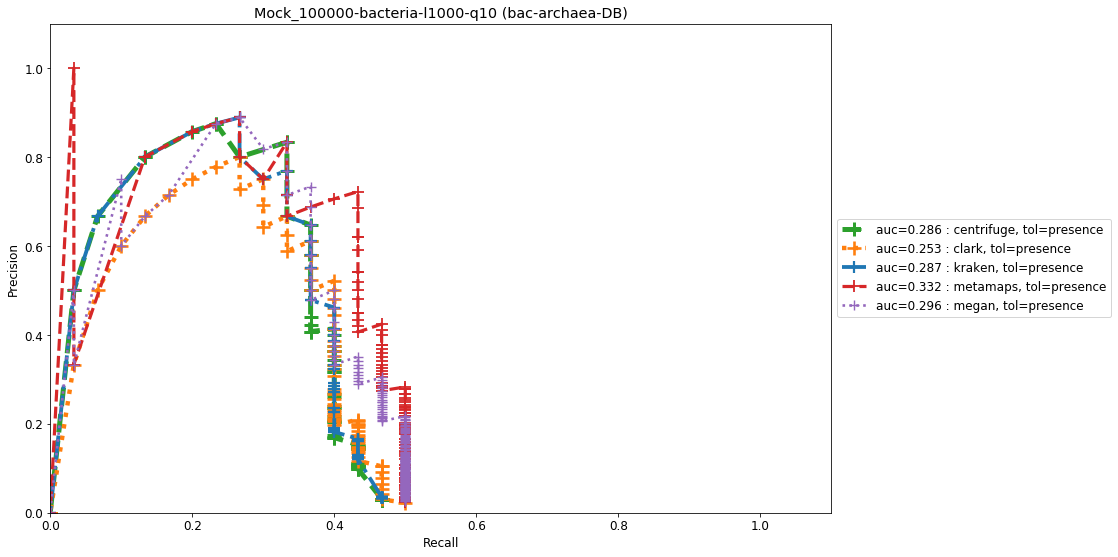

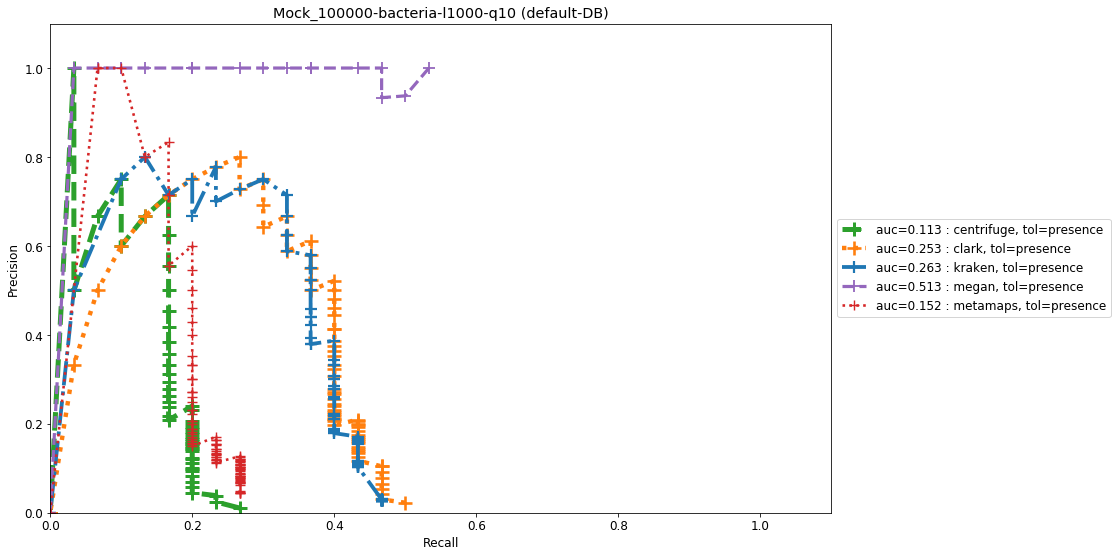

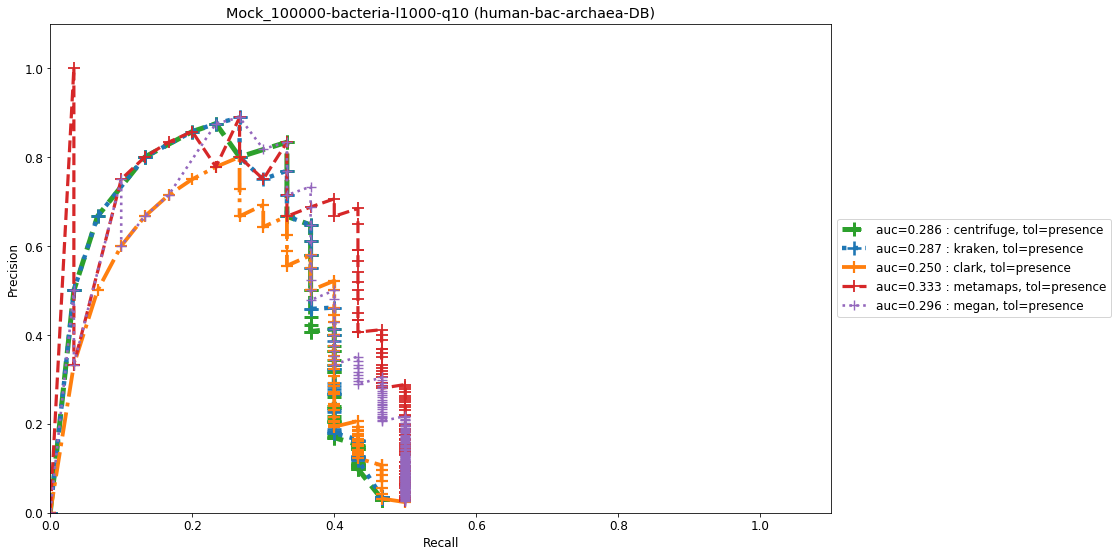

In [43]:
tolerances = [0, ]
comparison = {}
reports = {}
all_reports = {}
gt = {}
gt_file = "_ground_truth.pd"
for fastq in Path(folder_report).rglob(gt_file):
    k      = fastq.parent.name
    parent = fastq.parent.parent.name
    if "Mock_100000-bacteria-l1000-q10" not in k or "" not in parent:
        print(f"skipping.. {k} ({parent})")
    else:
        print(f"processing {k} ({parent})")
        output = osp.join(folder_fig, k)
        os.makedirs(output, exist_ok=True)
        output = osp.join(output, k)

        comparison[k], all_reports[k], reports[k], gt[k] = load_all(
            fastq.parent, output)
        plot_auc_comparison(gt[k], reports[k], output, f"{k} ({parent})", tolerance=tolerances)

skipping.. 2019-12-05_100000-WindowReads_20-BacGut (bac-archaea-DB)
processing Mock_100000-bacteria-l1000-q10 (bac-archaea-DB)
retrieval of the lineage of 0 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -1 failed
retrieval of the lineage of -2 failed
skipping.. silico-30p-human-70p-bac (bac-archaea-DB)
skipping.. silico-human-dengue (bac-archaea-DB)
skipping.. 2019-12-05_100000-WindowReads_20-BacGut (default-DB)
skipping.. 2019-12-19_20-WindowReads_10-EColiTest (default-DB)
processing Mock_100000-bacteria-l1000-q10 (default-DB)
retrieval of the lineage of 0 failed


/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 1715259 was translated into 1334193
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 1870930 was translated into 1812935
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 330 was translated into 301
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 319938 was translated into 288004
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 86

retrieval of the lineage of 0 failed


/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 538219 was translated into 353852
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/ubuntu/.local/lib/python3.6/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:240: UserWarning: taxid 2183547 was translated into 998844
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


retrieval of the lineage of -1 failed
retrieval of the lineage of -2 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
skipping.. silico-30p-human-70p-bac (default-DB)
skipping.. silico-human-dengue (default-DB)
skipping.. 2019-12-05_100000-WindowReads_20-BacGut (human-bac-archaea-DB)
processing Mock_100000-bacteria-l1000-q10 (human-bac-archaea-DB)
retrieval of the lineage of 0 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of 2715163 failed
retrieval of the lineage of 2715164 failed
retrieval of the lineage of 0 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -3 failed
retrieval of the lineage of -1 failed
retrieval of the lineage of -2 failed
skipping.. silico-30p-human-70p-bac (human-bac-archaea-DB)
skipping.. silico-human-dengue (human-bac-archaea-DB)


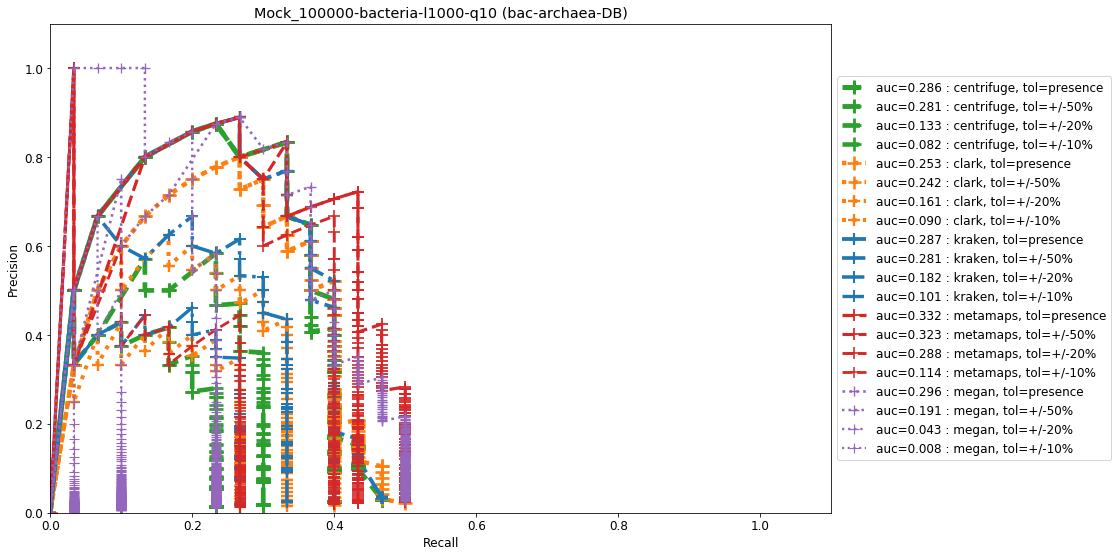

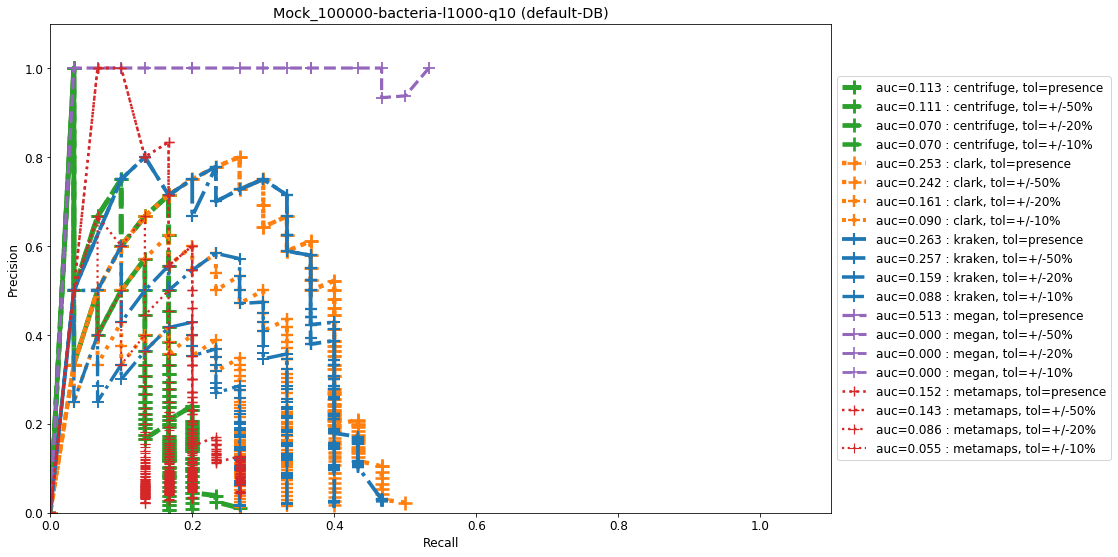

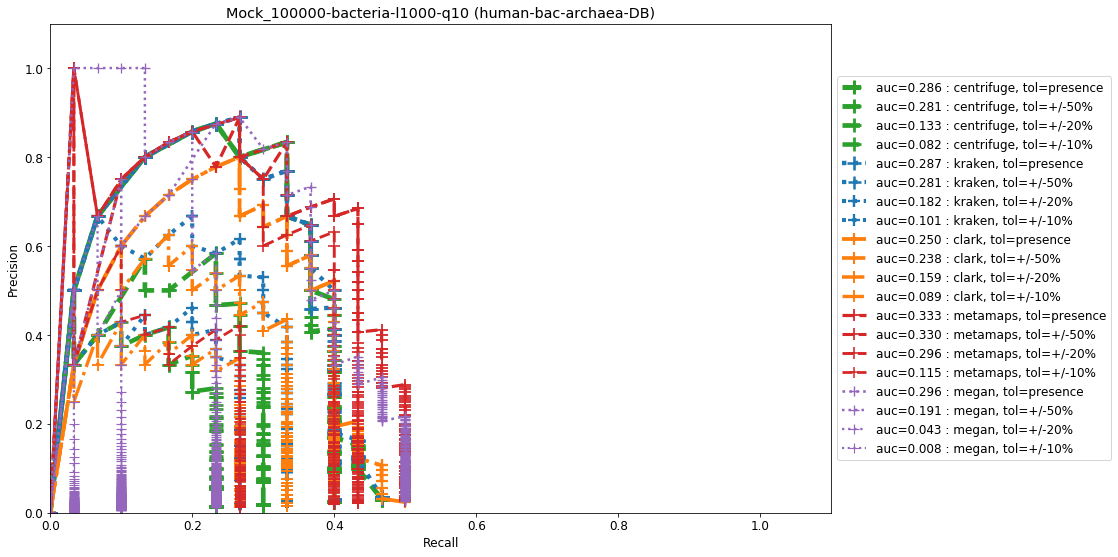

In [46]:
tolerances = [0, 0.5, 0.2, 0.1]
comparison = {}
reports = {}
all_reports = {}
gt = {}
gt_file = "_ground_truth.pd"

for fastq in Path(folder_report).rglob(gt_file):
    k      = fastq.parent.name
    parent = fastq.parent.parent.name
    if "Mock_100000-bacteria-l1000-q10" not in k or "" not in parent:
        print(f"skipping.. {k} ({parent})")
    else:
        print(f"processing {k} ({parent})")
        output = osp.join(folder_fig, k)
        os.makedirs(output, exist_ok=True)
        output = osp.join(output, k)

        comparison[k], all_reports[k], reports[k], gt[k] = load_all(
            fastq.parent, output)
        plot_auc_comparison(gt[k], reports[k], output, f"{k} ({parent})", tolerance=tolerances)

In [47]:
sorted_df = comparison["Mock_100000-bacteria-l1000-q10"].sort_values(by=["ground_truth"], ascending=False).head(100)
sorted_df.style\
.apply(lambda x: ["background: lightgreen" if isinstance(v, float) and v is not x.iloc[0] and abs(v - x.iloc[0]) <= x.iloc[0]*0.1 else "" for v in x], axis = 1)\
.apply(lambda x: ["background: yellow" if isinstance(v, float) and abs(v - x.iloc[0]) > x.iloc[0]*0.1 else "" for v in x], axis = 1)\
.apply(lambda x: ["background: orange" if isinstance(v, float) and abs(v - x.iloc[0]) > x.iloc[0]*0.2 else "" for v in x], axis = 1)\
.apply(lambda x: ["background: red" if isinstance(v, float) and abs(v - x.iloc[0]) > x.iloc[0]*0.5 else "" for v in x], axis = 1)\
.bar(subset=["ground_truth"], color="lightblue", vmin=0, vmax=sorted_df.ground_truth.max())\
.set_properties(subset=['species_name'], **{'width': '200px'})
# .apply(lambda x: ["background: lightgreen" if isinstance(v, float) and v is not x.iloc[0] and abs(v - x.iloc[0]) <= x.iloc[0]*0.1 else "" for v in x], axis = 1)

In [48]:
comparison.keys()

dict_keys(['Mock_100000-bacteria-l1000-q10'])

In [49]:
styled_r = style_report(comparison["Mock_100000-bacteria-l1000-q10"])
styled_r

In [75]:
df = comparison["Mock_100000-bacteria-l1000-q10"]

In [76]:
df.sum().tolist() + ["classified"]

[400.0, 395.2936720000001, 400.0, 391.153412, 4.000004, 'classified']

In [77]:
df.loc["classified"] = df.sum().tolist() + ["classified reads"]

In [78]:
df

ground_truth  centrifuge    clark     kraken  metamaps  \
0                    0.0    25.23342    0.000   14.39082   0.58407   
9                    0.0     0.03000    0.011    0.03930   0.00001   
24                   0.0     0.03000    0.001    0.00000   0.00000   
56                   0.0     0.00000    0.003    0.00000   0.00000   
72                   0.0     0.00000    0.000    0.01000   0.00000   
...                  ...         ...      ...        ...       ...   
2697370              0.0     0.00000    0.001    0.00000   0.00000   
2698686              0.0     0.00000    0.001    0.00000   0.00000   
2698804              0.0     0.00000    0.002    0.00000   0.00000   
-1                 100.0    98.82342  100.000   97.78835   1.00000   
classified         400.0   395.29367  400.000  391.15341   4.00000   

                        species_name  
0                                  0  
9                Buchnera aphidicola  
24           Shewanella putrefaciens  
56              Sorangium cellulosum  
72              Simonsiella muelleri  
...                              ...  
2697370        Citrobacter sp. LUTT5  
2698686       Shewanella sp. Arc9-LZ  
2698804     Streptococcus sp. CNU G3  
-1                        classified  
classified          classified reads  

[1582 rows x 6 columns]

In [74]:
df.sort_values(by=["ground_truth"])

ground_truth  centrifuge    clark     kraken  metamaps  \
0                   0.00    25.23342    0.000   14.39082   0.58407   
891974              0.00     0.01000    0.001    0.00000   0.00000   
889453              0.00     0.00000    0.000    0.01000   0.00000   
885040              0.00     0.00000    0.002    0.00000   0.00000   
881260              0.00     0.00000    0.006    0.00000   0.00000   
...                  ...         ...      ...        ...       ...   
1313               12.00    11.81000   11.879   11.92623   0.12038   
335972             14.00     0.00000    0.000    0.00000   0.00000   
1667024            18.06     0.00000    0.000    0.00000   0.00000   
-1                100.00    98.82342  100.000   97.78835   1.00000   
classified        200.00   197.64684  200.000  195.57671   2.00000   

                        species_name  
0                                  0  
891974        Plautia stali symbiont  
889453       Alkalitalea saponilacus  
885040             Enterobacter soli  
881260      Enterobacter bugandensis  
...                              ...  
1313        Streptococcus pneumoniae  
335972              Vibrio litoralis  
1667024             Vibrio algivorus  
-1                        classified  
classified                classified  

[1582 rows x 6 columns]

In [ ]:
comparison["total"] = comparison.sum()

In [90]:
comparison.keys()

dict_keys(['Mock_100000-bacteria-l1000-q10', 'silico-30p-human-70p-bac', 'silico-human-dengue', '2019-12-05_100000-WindowReads_20-BacGut'])

In [37]:
style_report(comparison["2019-12-05_100000-WindowReads_20-BacGut"])

In [97]:
df = pd.read_csv("/mnt/data/results/bac-archaea-DB/silico-30p-human-70p-bac.tsv", sep="\t")
df.sort_values(by=["ground_truth"], ascending=False)

In [48]:
c = comparison["Mock_100000-bacteria-l1000-q10"].copy()
c["pred"] = (c.sum(axis=1, numeric_only=True) - c.ground_truth - c.megan) / 4
c.sort_values(by=["pred"], ascending=False, inplace=True)
c

ground_truth  centrifuge  kraken  clark  metamaps   megan  \
0               0.000      16.160  14.867  0.003    23.426 511.520   
76258           0.000      13.310  15.130 12.334    11.614   6.949   
1313           12.000      11.795  11.893 11.870    12.017  10.902   
1891186         9.000      10.910  10.680 10.648    10.368  10.740   
109328          8.000       7.880   7.880  7.909     7.933   1.667   
...               ...         ...     ...    ...       ...     ...   
1326            0.000       0.000   0.000  0.000     0.000   0.000   
1318            0.000       0.000   0.000  0.000     0.000   0.000   
29562           0.000       0.000   0.000  0.000     0.000   0.000   
1310            0.000       0.000   0.000  0.000     0.000   0.000   
76124           0.000       0.000   0.000  0.000     0.000   0.000   

                        species_name   pred  
0                                  0 13.614  
76258              Vibrio rumoiensis 13.097  
1313        Streptococcus pneumoniae 11.894  
1891186            Vibrio aphrogenes 10.652  
109328       Leptotrichia trevisanii  7.900  
...                              ...    ...  
1326      Streptococcus acidominimus  0.000  
1318     Streptococcus parasanguinis  0.000  
29562       Mycoplasma ovipneumoniae  0.000  
1310          Streptococcus sobrinus  0.000  
76124          [Eubacterium] minutum  0.000  

[1583 rows x 8 columns]

In [112]:
def within_bonds(c, tolerance=0.2, threshold=0.00, styling=True, col="kraken"):
    if not styling:
        return abs(c[col] - c.ground_truth) <= tolerance * c.ground_truth
    else:
        is_ok = []
        for col in c.index:
            if any(("species" in col, "Megan" in col)): 
                res = True
            else:
                res = abs(c[col] - c.ground_truth) <= tolerance * c.ground_truth + threshold
            is_ok.append(res)
#         print(c)
#         print(is_ok)
#         print(["color: red" if v else "" for v in is_ok])
        return ["" if v else "color: red" for v in is_ok]

In [109]:
def abundance_score(c, tolerance=0.5):
    scores = {}
    nb_species = sum(c.ground_truth > 0)
    for col in c.columns:
        if "truth" in col or "species" in col:  continue 
        score = sum(within_bonds(c, styling=False, col=col)) / nb_species
        scores[col] = score
    return scores

In [110]:
scores = abundance_score(c, 0.9)
scores

{'centrifuge': 60.333333333333336,
 'kraken': 64.44444444444444,
 'clark': 33.0,
 'metamaps': 55.888888888888886,
 'megan': 56.888888888888886,
 'pred': 7.444444444444445}

In [113]:
c.style.apply(within_bonds, axis=1)

In [ ]:
# ranking of predicted species

In [ ]:
def false_positives(comparison):
#     todo: plot false positives
    max_val = 1.01 * comparison.max(numeric_only=True).max()
    subset = comparison[comparison.ground_truth > 0].sort_values(ascending=False, by=["ground_truth", ])
    return subset.style.bar(color="#d65f5f", vmin=0, vmax=max_val).bar(subset=["ground_truth"], color="#5fba7d", vmin=0, vmax=max_val)

In [ ]:
styled_r = style_report(comparison["silico-30p-human-70p-bac"])
styled_r

# End of main script

In [ ]:
gt = Report("GT", folder_reports)
gt.load_gt(path_gt)
gt.normalize()

In [ ]:
full = Report("full", folder_reports, )
full.load_full([f for f in os.listdir(folder_reports) if "full" in f and f.endswith(".report")][0])
full.normalize()

reports = {}
reports["full"] = full
params = ["3mer_s5", "3mer_s10", "4mer_s10", ] # "3mer_s10", 
for param in params:
    reports[param] = Report(param, folder_reports, )
    reports[param].load_multi([f for f in os.listdir(folder_reports) 
                                    if f"clustered_by_minikm_{param}000" in f and f.endswith(".report")])
    reports[param].normalize()

In [ ]:
max_val = 1.01 * gt.report.ground_truth.max()

subset = comparison[comparison.ground_truth > 0].sort_values(ascending=False, by=["ground_truth", ])
subset.style.bar(color="#d65f5f", vmin=0, vmax=max_val).bar(subset=["ground_truth"], color="#5fba7d", vmin=0, vmax=max_val)

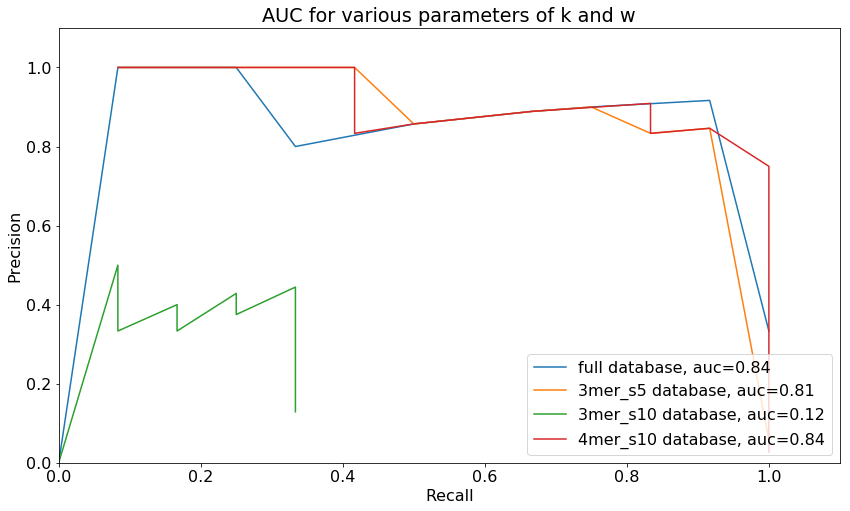

In [255]:
plot_auc_comparison(gt, reports)

In [38]:
max_val = 1.01 * comparison.ground_truth.max()
subset = comparison[comparison["4mer_s10"] > 0].sort_values(ascending=False, by=["4mer_s10", ])
subset.style.bar(color="#d65f5f", vmin=0, vmax=max_val).bar(subset=["ground_truth"], color="#5fba7d", vmin=0, vmax=max_val)

In [79]:
reports["full"].df_auc

threshold    tp    fn    fp   recall  precision
0     0.00000  12.0   0.0  25.0  1.00000    0.32432
1     0.00001  12.0   0.0  24.0  1.00000    0.33333
2     0.00002  11.0   1.0  18.0  0.91667    0.37931
3     0.00004  11.0   1.0  15.0  0.91667    0.42308
4     0.00008  11.0   1.0  11.0  0.91667    0.50000
5     0.00011  11.0   1.0   8.0  0.91667    0.57895
6     0.00012  11.0   1.0   6.0  0.91667    0.64706
7     0.00026  11.0   1.0   5.0  0.91667    0.68750
8     0.00032  11.0   1.0   4.0  0.91667    0.73333
9     0.00040  11.0   1.0   3.0  0.91667    0.78571
10    0.00072  11.0   1.0   2.0  0.91667    0.84615
11    0.00209  11.0   1.0   1.0  0.91667    0.91667
12    0.05265  10.0   2.0   1.0  0.83333    0.90909
13    0.05317   9.0   3.0   1.0  0.75000    0.90000
14    0.06337   8.0   4.0   1.0  0.66667    0.88889
15    0.06359   7.0   5.0   1.0  0.58333    0.87500
16    0.06412   6.0   6.0   1.0  0.50000    0.85714
17    0.06576   5.0   7.0   1.0  0.41667    0.83333
18    0.06943   4.0   8.0   1.0  0.33333    0.80000
19    0.11760   4.0   8.0   0.0  0.33333    1.00000
20    0.13233   3.0   9.0   0.0  0.25000    1.00000
21    0.15162   2.0  10.0   0.0  0.16667    1.00000
22    0.16156   1.0  11.0   0.0  0.08333    1.00000
23    0.16156   1.0  11.0   0.0  0.00000    1.00000

# Fix various ground truth formats

In [117]:
paths = {
    "20_WindowReads_EColi": ("/hdd1000/Reports/2019-12-19_20-WindowReads_10-EColiTest",
                             "/hdd1000/Segmentation/Test-Data/Synthetic_from_Genomes/2019-12-19_20-WindowReads_EColi_Test/2019-12-19_20-WindowReads_10-EColiTest.GT.pd"),
    "100k_WindowReads_20BacGut": ("/hdd1000/Reports/2019-12-05_100000-WindowReads_20-BacGut",
                                  "/hdd1000/Segmentation/Test-Data/Synthetic_from_Genomes/2019-12-05_100000-WindowReads_20-BacGut/2019-12-05_100000-WindowReads_20-BacGut.GT.pd"),
    "100k-SyntReads_20-BacGut": ("/hdd1000/Reports/2019-11-26_100000-SyntReads_20-BacGut",
                                 "/hdd1000/Segmentation/Test-Data/Synthetic_from_Genomes/2019-11-26_100000-SyntReads_20-BacGut/2019-11-26_100000-SyntReads_20-BacGut.pd"),
#     "10k_Mock_UniformBac_l1000q8": ("/hdd1000/Reports/Mock_10000-uniform-bacteria-l1000-q8",
#                                     "/ssd1500/Segmentation/Test-Data/ONT_Silico_Communities/Mock_10000-uniform-bacteria_reads_details.pd"),
#     "10k_Mock_VariousBac_l1000q8": ("/hdd1000/Reports/Mock_100000-bacteria-l1000-q10",
#                                     "/ssd1500/Segmentation/Test-Data/ONT_Silico_Communities/Mock_100000-bacteria-l1000-q10_reads_details.pd"),
    
}

In [14]:
path_gt = "/mnt/data/reads-fastq/ONT/communities-silico/Mock_100000-bacteria-l1000-q10_reads_details.pd"

In [15]:
df = pd.read_pickle(path_gt)

In [16]:
df

read_id   quality  length     taxo  \
8433     SRR5891470.8434  11.48449   12382      470   
14659   SRR5891470.14660  12.53888    6623      470   
18841   SRR5891470.18842  15.82774   13369      470   
13682   SRR5891470.13683  14.66977   19138      470   
12734   SRR5891470.12735  11.80230    4092      470   
...                  ...       ...     ...      ...   
30188    DRR129658.30189  20.75438   11534  1667024   
142368  DRR129658.142369  18.97412    2628  1667024   
25701    DRR129658.25702  19.69108   13107  1667024   
159472  DRR129658.159473  22.54743    1012  1667024   
73663    DRR129658.73664  16.94152    2223  1667024   

                           species   kingdom  \
8433       acinetobacter_baumannii  bacteria   
14659      acinetobacter_baumannii  bacteria   
18841      acinetobacter_baumannii  bacteria   
13682      acinetobacter_baumannii  bacteria   
12734      acinetobacter_baumannii  bacteria   
...                            ...       ...   
30188   vibrio_algivorus_dsm_29824  bacteria   
142368  vibrio_algivorus_dsm_29824  bacteria   
25701   vibrio_algivorus_dsm_29824  bacteria   
159472  vibrio_algivorus_dsm_29824  bacteria   
73663   vibrio_algivorus_dsm_29824  bacteria   

                                                file_path  line_nb date_added  
8433    ../../../Data/ONT_isolates/Acinetobacter_bauma...    33732 2018-10-11  
14659   ../../../Data/ONT_isolates/Acinetobacter_bauma...    58636 2018-10-11  
18841   ../../../Data/ONT_isolates/Acinetobacter_bauma...    75364 2018-10-11  
13682   ../../../Data/ONT_isolates/Acinetobacter_bauma...    54728 2018-10-11  
12734   ../../../Data/ONT_isolates/Acinetobacter_bauma...    50936 2018-10-11  
...                                                   ...      ...        ...  
30188            ../../../Data/ONT_isolates/DRR129658.txt   120752 2019-02-21  
142368           ../../../Data/ONT_isolates/DRR129658.txt   569472 2019-02-21  
25701            ../../../Data/ONT_isolates/DRR129658.txt   102804 2019-02-21  
159472           ../../../Data/ONT_isolates/DRR129658.txt   637888 2019-02-21  
73663            ../../../Data/ONT_isolates/DRR129658.txt   294652 2019-02-21  

[100000 rows x 9 columns]

In [17]:
df.rename(columns={"taxo": "taxon"}, inplace=True)

In [18]:
df["species"] = ncbi.translate_to_names(get_list_rank(df.taxon))

In [19]:
df

read_id   quality  length    taxon                  species  \
8433     SRR5891470.8434  11.48449   12382      470  Acinetobacter baumannii   
14659   SRR5891470.14660  12.53888    6623      470  Acinetobacter baumannii   
18841   SRR5891470.18842  15.82774   13369      470  Acinetobacter baumannii   
13682   SRR5891470.13683  14.66977   19138      470  Acinetobacter baumannii   
12734   SRR5891470.12735  11.80230    4092      470  Acinetobacter baumannii   
...                  ...       ...     ...      ...                      ...   
30188    DRR129658.30189  20.75438   11534  1667024         Vibrio algivorus   
142368  DRR129658.142369  18.97412    2628  1667024         Vibrio algivorus   
25701    DRR129658.25702  19.69108   13107  1667024         Vibrio algivorus   
159472  DRR129658.159473  22.54743    1012  1667024         Vibrio algivorus   
73663    DRR129658.73664  16.94152    2223  1667024         Vibrio algivorus   

         kingdom                                          file_path  line_nb  \
8433    bacteria  ../../../Data/ONT_isolates/Acinetobacter_bauma...    33732   
14659   bacteria  ../../../Data/ONT_isolates/Acinetobacter_bauma...    58636   
18841   bacteria  ../../../Data/ONT_isolates/Acinetobacter_bauma...    75364   
13682   bacteria  ../../../Data/ONT_isolates/Acinetobacter_bauma...    54728   
12734   bacteria  ../../../Data/ONT_isolates/Acinetobacter_bauma...    50936   
...          ...                                                ...      ...   
30188   bacteria           ../../../Data/ONT_isolates/DRR129658.txt   120752   
142368  bacteria           ../../../Data/ONT_isolates/DRR129658.txt   569472   
25701   bacteria           ../../../Data/ONT_isolates/DRR129658.txt   102804   
159472  bacteria           ../../../Data/ONT_isolates/DRR129658.txt   637888   
73663   bacteria           ../../../Data/ONT_isolates/DRR129658.txt   294652   

       date_added  
8433   2018-10-11  
14659  2018-10-11  
18841  2018-10-11  
13682  2018-10-11  
12734  2018-10-11  
...           ...  
30188  2019-02-21  
142368 2019-02-21  
25701  2019-02-21  
159472 2019-02-21  
73663  2019-02-21  

[100000 rows x 9 columns]

In [20]:
df.to_pickle(path_gt)

In [83]:
collated_report.style.bar(subset=["percentage", "full_DB_per", "bins_DB_per"], color=['#d65f5f', '#5fba7d'],
                          vmin=0, vmax=15.5, align="left", ) \
    .set_properties(subset=['name'], **{'width': '200px'})

In [84]:
collated_report.rename(columns={"percentage": "ground_truth_per"}).style.background_gradient(subset=["ground_truth_per", "full_DB_per", "bins_DB_per"], cmap="Blues").set_properties(subset=['name'], **{'width': '200px'})

In [ ]:
# Good pandas plots
# http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
# https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

In [ ]:
# summuray_df[['species', 'taxonomy_id', 'kingdom', 'nb_of_reads',
#        'requested', 'available', 'percentage']]